In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns
import gc
import re as re
from collections import Counter

from tqdm.auto import tqdm
tqdm.pandas()
import math
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import log_loss, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from xgboost import XGBClassifier

import time

In [3]:
path_train = '/kaggle/input/icr-identify-age-related-conditions/train.csv'
path_test = '/kaggle/input/icr-identify-age-related-conditions/test.csv'
path_submission = '/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv'

train =  pd.read_csv(path_train).drop(columns='Id')

In [4]:
train.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [5]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [6]:
summary(train)

data shape: (617, 57)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
AB,float64,0,0.000000,217,0.081187,6.161666,0.209377,0.145282,0.47003
AF,float64,0,0.000000,599,192.59328,28688.18766,3109.03329,978.76416,2635.10654
AH,float64,0,0.000000,227,85.200147,1910.123198,85.200147,85.200147,85.200147
AM,float64,0,0.000000,605,3.177522,630.51823,22.394407,36.968889,32.360553
AR,float64,0,0.000000,130,8.138688,178.943634,8.138688,8.138688,8.138688
AX,float64,0,0.000000,427,0.699861,38.27088,0.699861,3.63219,6.73284
AY,float64,0,0.000000,148,0.025578,10.315851,0.025578,0.025578,0.025578
AZ,float64,0,0.000000,484,3.396778,38.971568,9.812214,13.51779,12.82457
BC,float64,0,0.000000,259,1.2299,1463.693448,5.555634,1.2299,1.2299
BD,float64,0,0.000000,617,1693.62432,53060.59924,4126.58731,5496.92824,5135.78024


In [4]:
# выбирают числовые и категориальные переменные соответственно
num_cols = train.select_dtypes(include=['float64']).columns.tolist()
cat_cols = 'EJ'
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

In [8]:
fig2 = px.pie(train, names='Class', 
             height=400, width=600, 
             hole=0.7, 
             title='target class Overview',
                   color_discrete_sequence=['#4c78a8', '#72b7b2'])
fig2.update_traces(hovertemplate=None, textposition='outside', textinfo='percent+label', rotation=0)
fig2.update_layout(margin=dict(t=100, b=30, l=0, r=0), showlegend=False,
                        plot_bgcolor='#ffffff', paper_bgcolor='#ffffff',
                        title_font=dict(size=20, color='#555', family="Lato, sans-serif"),
                        font=dict(size=17, color='#8a8d93'),
                        hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))
fig2.show()

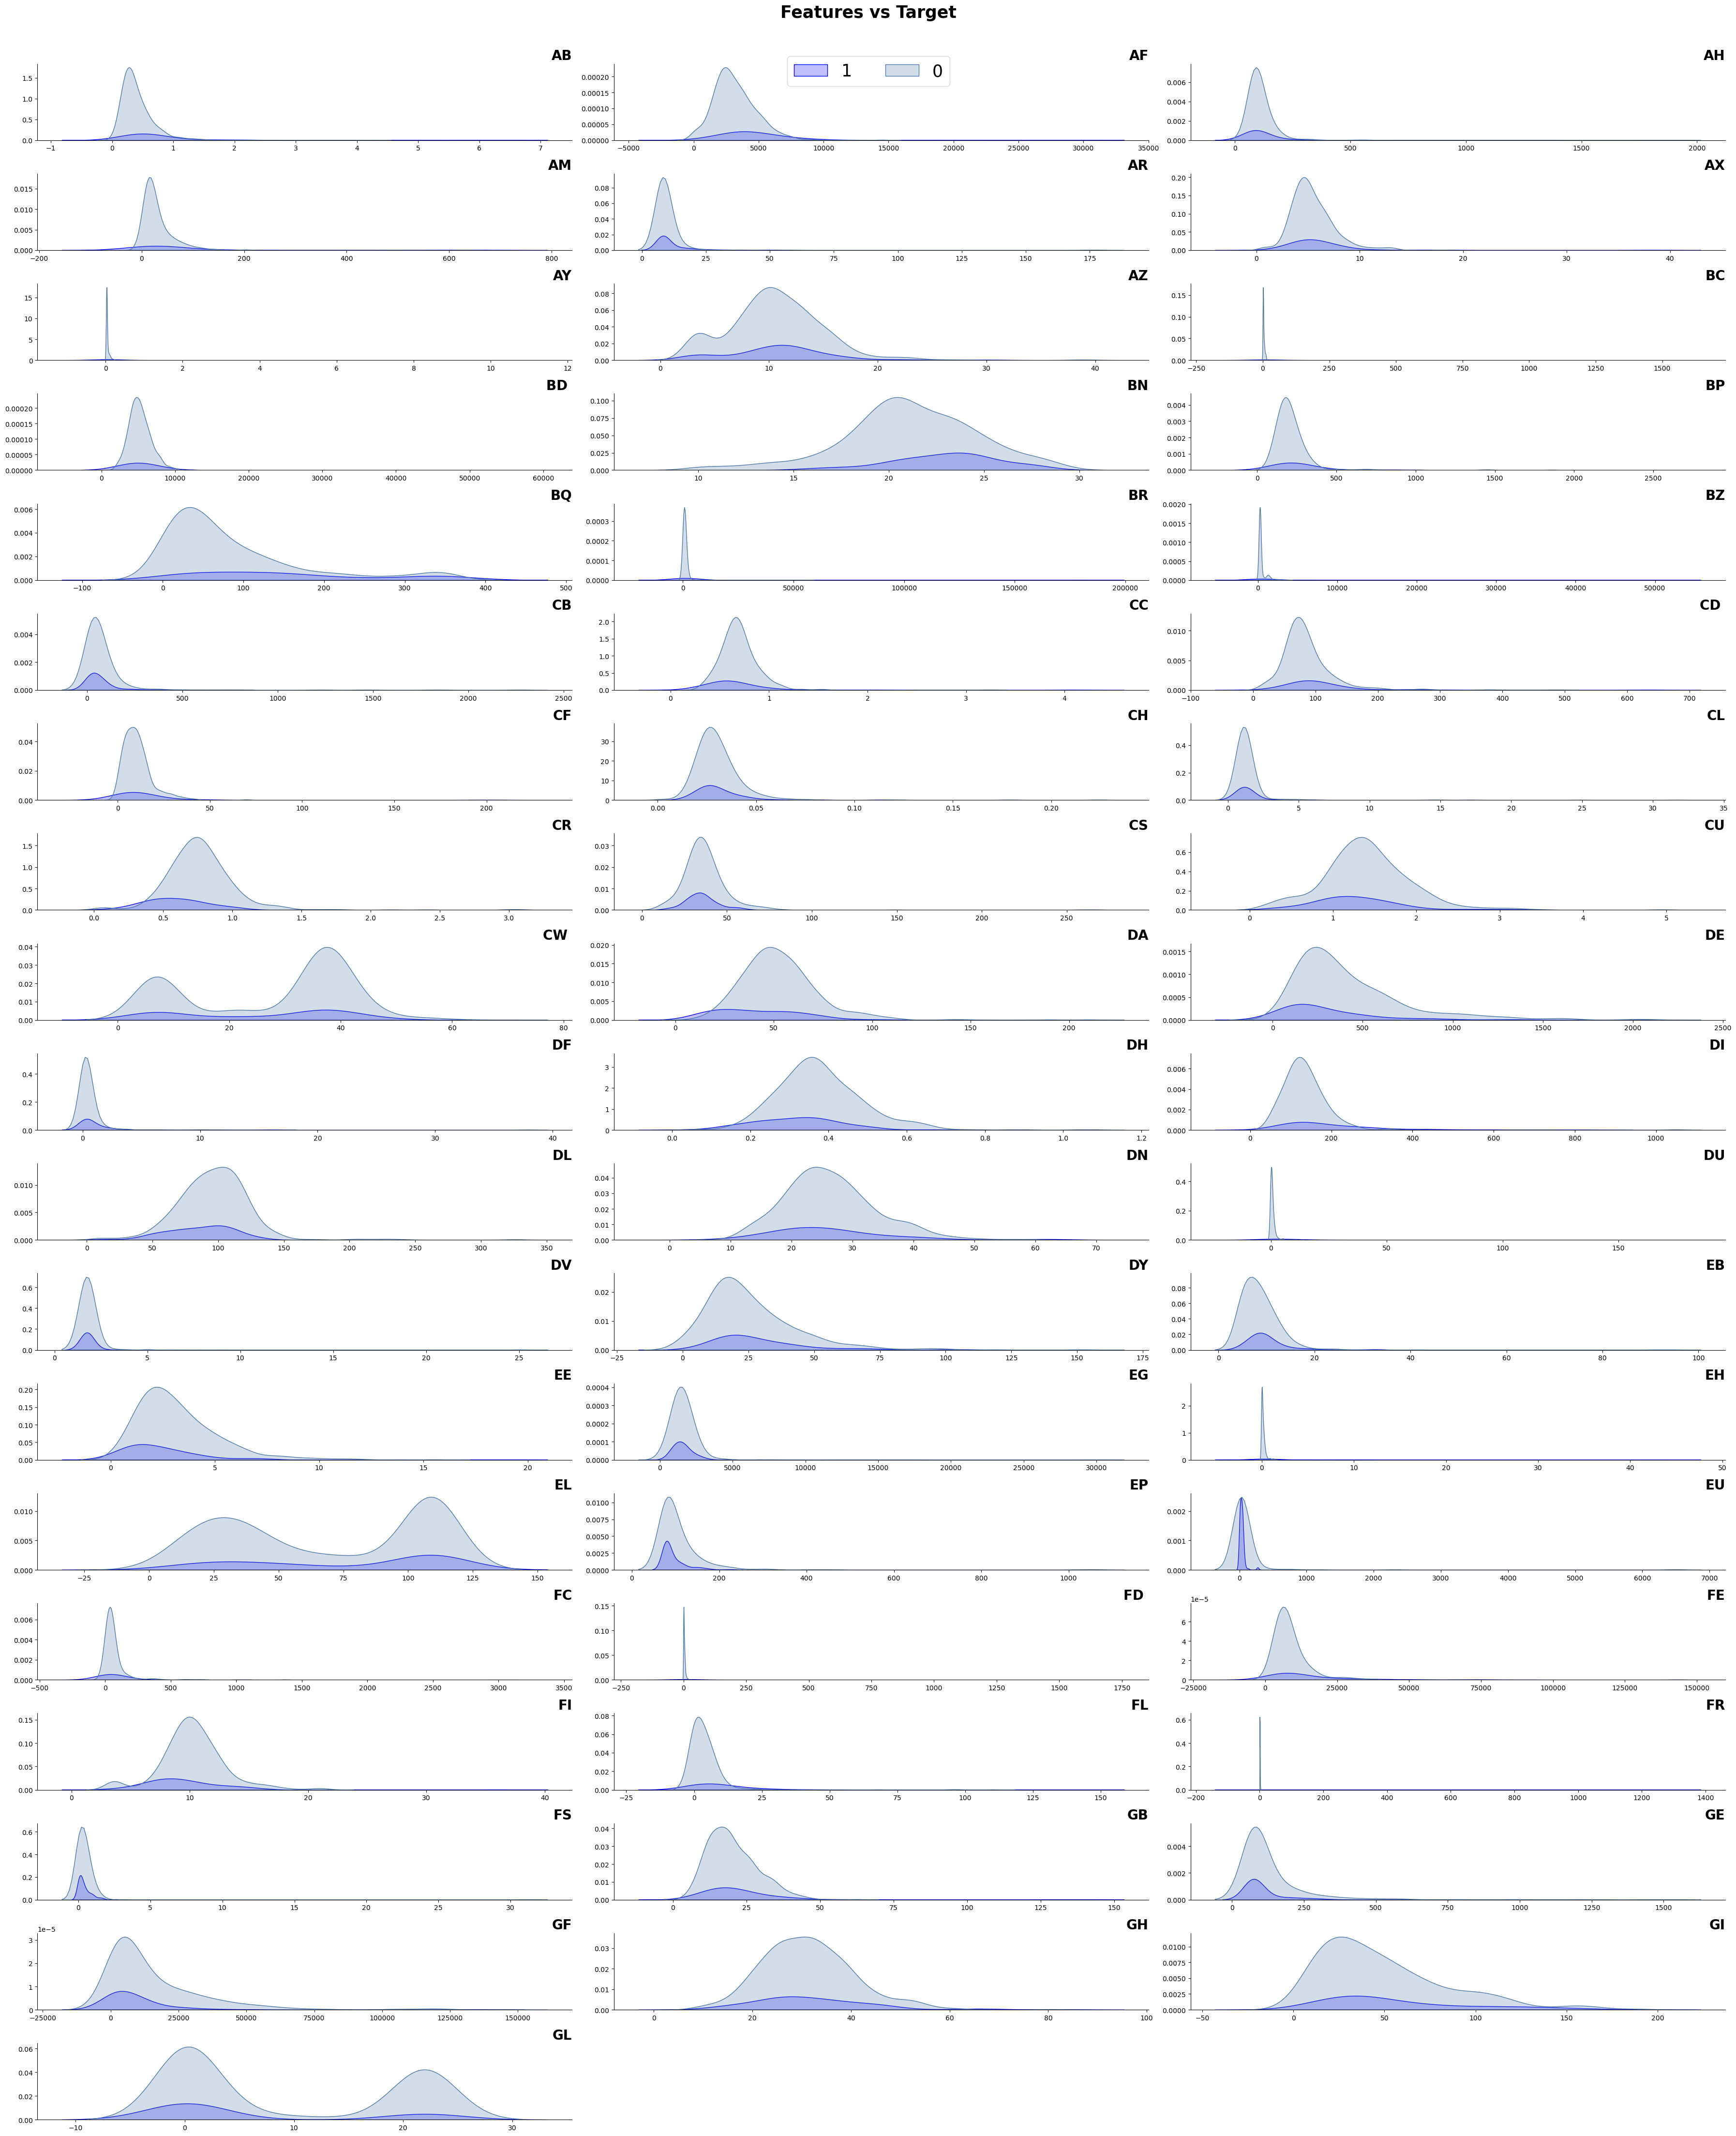

CPU times: user 25.4 s, sys: 12.5 s, total: 37.8 s
Wall time: 17.3 s


In [9]:
%%time
figsize = (6*6, 45)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(num_cols):
    ax = plt.subplot(19,3, idx + 1)
    sns.kdeplot(
        data=train, hue='Class', fill=True,
        x=col, palette=['#4c78a8', 'blue'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()
plt.show()

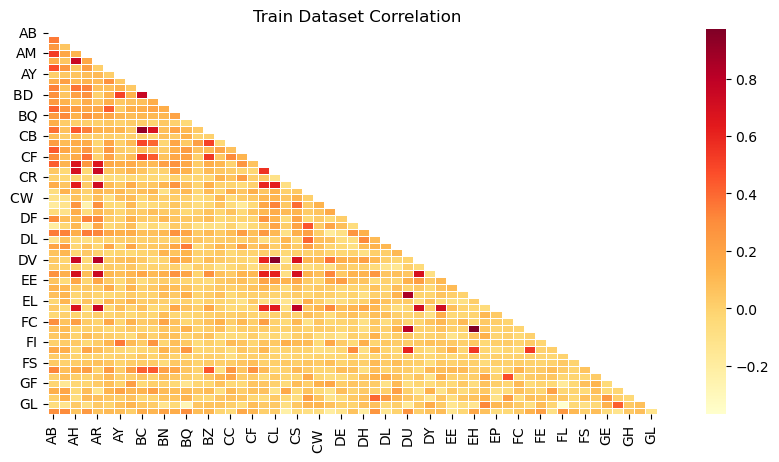

In [10]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
   
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(10, 5))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5,  cmap='YlOrRd', annot=False)
    plt.title(title_name)
    plt.show()

plot_correlation_heatmap(train, 'Train Dataset Correlation')

In [5]:
# Объедините числовые и категориальные признаки
features = num_cols + cat_cols

# Заполните отсутствующие значения средним значением для числовых переменных
imputer = SimpleImputer(strategy='mean')
numeric_df = pd.DataFrame(imputer.fit_transform(train[num_cols]), columns=num_cols)

# Масштабирование числовых переменных с использованием минимаксного масштабирования
scaler = MinMaxScaler()
scaled_numeric_df = pd.DataFrame(scaler.fit_transform(numeric_df), columns=num_cols)

# Кодирование категориальных переменных
encoder = LabelEncoder()
encoded_cat_df = pd.DataFrame(encoder.fit_transform(train['EJ']), columns=['EJ'])   

# Конкатенация масштабированных числовых и кодированных категориальных переменных
processed_df = pd.concat([scaled_numeric_df, encoded_cat_df], axis=1)

processed_df.columns = processed_df.columns.str.replace(' ', '')


In [7]:
X = processed_df
y = train['Class']

# xgboost

In [13]:
%%time
# Определим параметры для подбора
params_xgb = {
    'colsample_bytree': np.arange(0.3, 1, 0.05),
    'gamma': np.arange(0, 10e-06, 1e-07),
    'learning_rate': np.linspace(0.1, 0.5, 50), # 50 значений от 0.1 до 0.5
    'max_depth': np.arange(2, 15, 1), # от 2 до 15 с шагом 1
    'reg_alpha': np.linspace(0, 2e-07, 100),
    'reg_lambda': np.linspace(0, 3e-07, 100),
    'n_estimators': np.arange(100, 3000, 100),
    'subsample': np.arange(0.3, 1, 0.05)
}

# Создадим объект XGBRegressor с параметрами по умолчанию и random_state для воспроизводимости
regressor_xgb = xgb.XGBRegressor(random_state=42)

# Создадим объект RandomizedSearchCV для поиска оптимальных значений параметров
search = RandomizedSearchCV(
    estimator=regressor_xgb,
    param_distributions=params_xgb,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Запустим поиск оптимальных значений параметров на обучающих данных
search.fit(X,y)

# Выведем лучшие значения параметров
best_params_xgb = search.best_params_ # словарь с лучшими значениями параметров
print(f'Best parameters xgb: {best_params_xgb}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters xgb: {'subsample': 0.7, 'reg_lambda': 5.454545454545454e-08, 'reg_alpha': 2.0202020202020203e-09, 'n_estimators': 1100, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 7.499999999999999e-06, 'colsample_bytree': 0.39999999999999997}
CPU times: user 10.5 s, sys: 413 ms, total: 10.9 s
Wall time: 14min 21s


In [8]:
%%time
from sklearn.utils import class_weight
from xgboost.callback import EarlyStopping

# Рассчитайте весовые коэффициенты выборки
weights = class_weight.compute_sample_weight('balanced', y) 

config = {'SEED': 127,
          'FOLDS': 14,
          'N_SPLITS': 3,
          'N_ESTIMATORS': 1300}

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'colsample_bytree': 0.59,
    'colsample_bylevel': 0.3,
    'gamma': 7.27e-06,
    'learning_rate': 0.1,
    'max_bin': 760, 
    'min_child_weight': 1,
    'reg_alpha': 1.69e-07,
    'reg_lambda': 2.87e-07,
    'subsample': 0.95,
    'early_stopping_rounds': 150,
    'n_jobs': -1,
    'verbosity': 0
}

cv = model_selection.RepeatedStratifiedKFold(n_repeats=config['N_SPLITS'], n_splits=config['FOLDS'], random_state=config['SEED'])
feature_importances_xgb = pd.DataFrame(index=X.columns)
metric = log_loss
eval_results_xgb = {}
models_xgb = []
oof_xgb = np.zeros(len(X))

for fold, (fit_idx, val_idx) in enumerate(cv.split(X, y), start=1):
    if (fold)%5 == 0 or (fold + 1) == 1:
        print(f'{"#"*24} Training FOLD {fold} {"#"*24}')

     # Split the dataset according to the fold indexes.
    X_fit = X.iloc[fit_idx]
    X_val = X.iloc[val_idx]
    y_fit = y.iloc[fit_idx]
    y_val = y.iloc[val_idx]
    
    # XGB .train() requires xgboost.DMatrix.
    fit_set = xgb.DMatrix(X_fit, y_fit)
    val_set = xgb.DMatrix(X_val, y_val)
    watchlist = [(fit_set, 'fit'), (val_set, 'val')]

    # Training.
    eval_results_xgb[fold] = {}
    model_xgb = xgb.train(
        num_boost_round=config['N_ESTIMATORS'],
        params=xgb_params,
        dtrain=fit_set,
        evals=watchlist,
        evals_result=eval_results_xgb[fold],
        verbose_eval=False,
        callbacks=[
            EarlyStopping(xgb_params['early_stopping_rounds'],
                          data_name='val', save_best=True)],
    )

    val_preds = model_xgb.predict(val_set)
    oof_xgb[val_idx] += val_preds / config['N_SPLITS']

    val_score = metric(y_val, val_preds)
    best_iter = model_xgb.best_iteration
    print(f'Fold: {fold:>3}| {metric.__name__}: {val_score:.5f}'
          f' | Best iteration: {best_iter:>4}')

    # Stores the feature importances
    feature_importances_xgb[f'gain_{fold}'] = feature_importances_xgb.index.map(model_xgb.get_score(importance_type='gain'))
    feature_importances_xgb[f'weight{fold}'] = feature_importances_xgb.index.map(model_xgb.get_score(importance_type='weight'))

    # Stores the model
    models_xgb.append(model_xgb)

mean_cv_score = metric(y, oof_xgb)
print(f'{"*" * 50}\nMean {metric.__name__}: {mean_cv_score:.5f}')

Fold:   1| log_loss: 0.17711 | Best iteration:  158
Fold:   2| log_loss: 0.11599 | Best iteration:  313
Fold:   3| log_loss: 0.10417 | Best iteration:  129
Fold:   4| log_loss: 0.13705 | Best iteration:  221
######################## Training FOLD 5 ########################
Fold:   5| log_loss: 0.11608 | Best iteration:  264
Fold:   6| log_loss: 0.13804 | Best iteration:  148
Fold:   7| log_loss: 0.05061 | Best iteration:  281
Fold:   8| log_loss: 0.21306 | Best iteration:   61
Fold:   9| log_loss: 0.10334 | Best iteration:  212
######################## Training FOLD 10 ########################
Fold:  10| log_loss: 0.28252 | Best iteration:   86
Fold:  11| log_loss: 0.06007 | Best iteration:  585
Fold:  12| log_loss: 0.30471 | Best iteration:   90
Fold:  13| log_loss: 0.07525 | Best iteration:  258
Fold:  14| log_loss: 0.18937 | Best iteration:   70
######################## Training FOLD 15 ########################
Fold:  15| log_loss: 0.17576 | Best iteration:  151
Fold:  16| log_loss:

# Оценка и визуализация

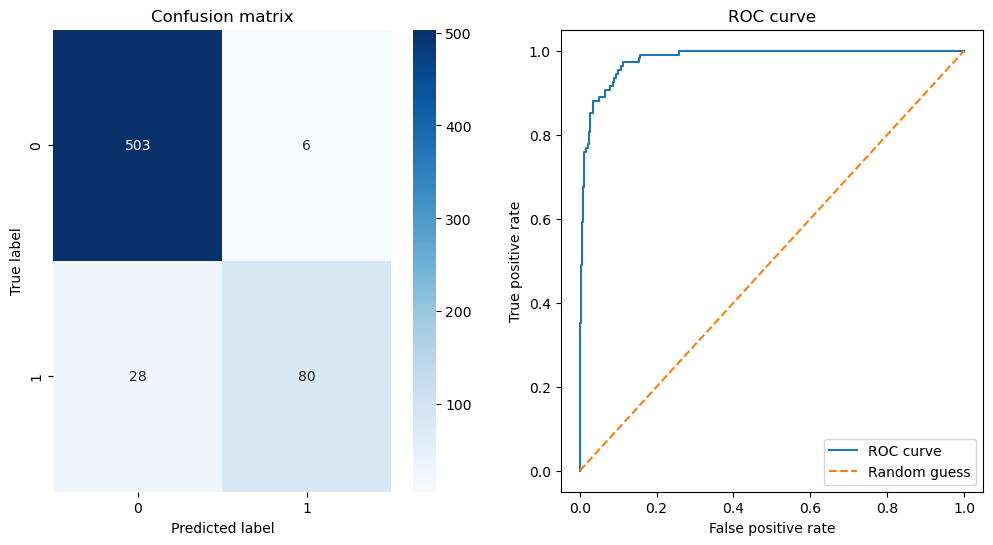

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay

# Вычисляем матрицу ошибок и кривую ROC
cm = confusion_matrix(y, oof_xgb.round())
fpr, tpr, thresholds = roc_curve(y, oof_xgb)

# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Рисуем матрицу ошибок на первом подграфике
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')
ax1.set_title('Confusion matrix')

# Рисуем кривую ROC на втором подграфике
ax2.plot(fpr, tpr, label='ROC curve')
ax2.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')
ax2.set_title('ROC curve')
ax2.legend()

# Показываем фигуру
plt.show()


# Probability Calibration

In [31]:
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

oof_df = pd.concat([y, pd.Series(oof_xgb)], axis=1)
oof_df.columns = ['target', 'preds']


lr = LogisticRegression(C=99999999999, solver='liblinear', max_iter=1000)
lr.fit(oof_df.preds.values.reshape(-1, 1), oof_df.target)
lr_preds_calibrated = lr.predict_proba(oof_df.preds.values.reshape(-1, 1))[:,1]

isor = IsotonicRegression(out_of_bounds='clip')
isor.fit(oof_df.preds.values.reshape(-1, 1), oof_df.target)
isor_preds_calibrated = isor.predict(oof_df.preds.values.reshape(-1, 1))

RF = RandomForestClassifier().fit(oof_df.preds.values.reshape(-1, 1), oof_df.target) # выстраивание случайного леса из исходного набора
rf_preds_calibrated = RF.predict_proba(oof_df.preds.values.reshape(-1, 1))[:,1] # прогностическая вероятность

logistic_regress = LogisticRegression().fit(rf_preds_calibrated.reshape(-1, 1), oof_df.target)
rf_logistic_regress = logistic_regress.predict_proba(rf_preds_calibrated.reshape(-1, 1))[:, 1]

isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(rf_preds_calibrated, oof_df.target) 
rf_isotonic_regress = isotonic_regress.predict(rf_preds_calibrated.reshape(-1, 1))

print(f'No calibration LogLoss:       {log_loss(oof_df.target, oof_df.preds):.5f}')
print(f'Platt calibration LogLoss:    {log_loss(oof_df.target, lr_preds_calibrated):.5f}')
print(f'Isotonic calibration LogLoss: {log_loss(oof_df.target, isor_preds_calibrated):.5f}')
print(f'RandomForest:    {log_loss(oof_df.target, rf_preds_calibrated):.5f}')
print(f'RandomForest+LR:    {log_loss(oof_df.target, rf_logistic_regress):.5f}')
print(f'RandomForest+Isotonic:    {log_loss(oof_df.target, rf_isotonic_regress):.5f}')

No calibration LogLoss:       0.14419
Platt calibration LogLoss:    0.15737
Isotonic calibration LogLoss: 0.11601
RandomForest:    0.03698
RandomForest+LR:    0.04088
RandomForest+Isotonic:    0.00000


Обнаружено, что изотоническая регрессия дает лучшую калибровку, чем масштабирование Платта. Результаты показали, что изотоническая регрессия привела к более низкому баллу логарифмической потери, чем логистическая регрессия после калибровки, что указывает на более точные оценки вероятности. Тем не менее, изотоническая регрессия имеет тенденцию к перенастройке калибровочной кривой, что может привести к нереалистичным скачкам. 

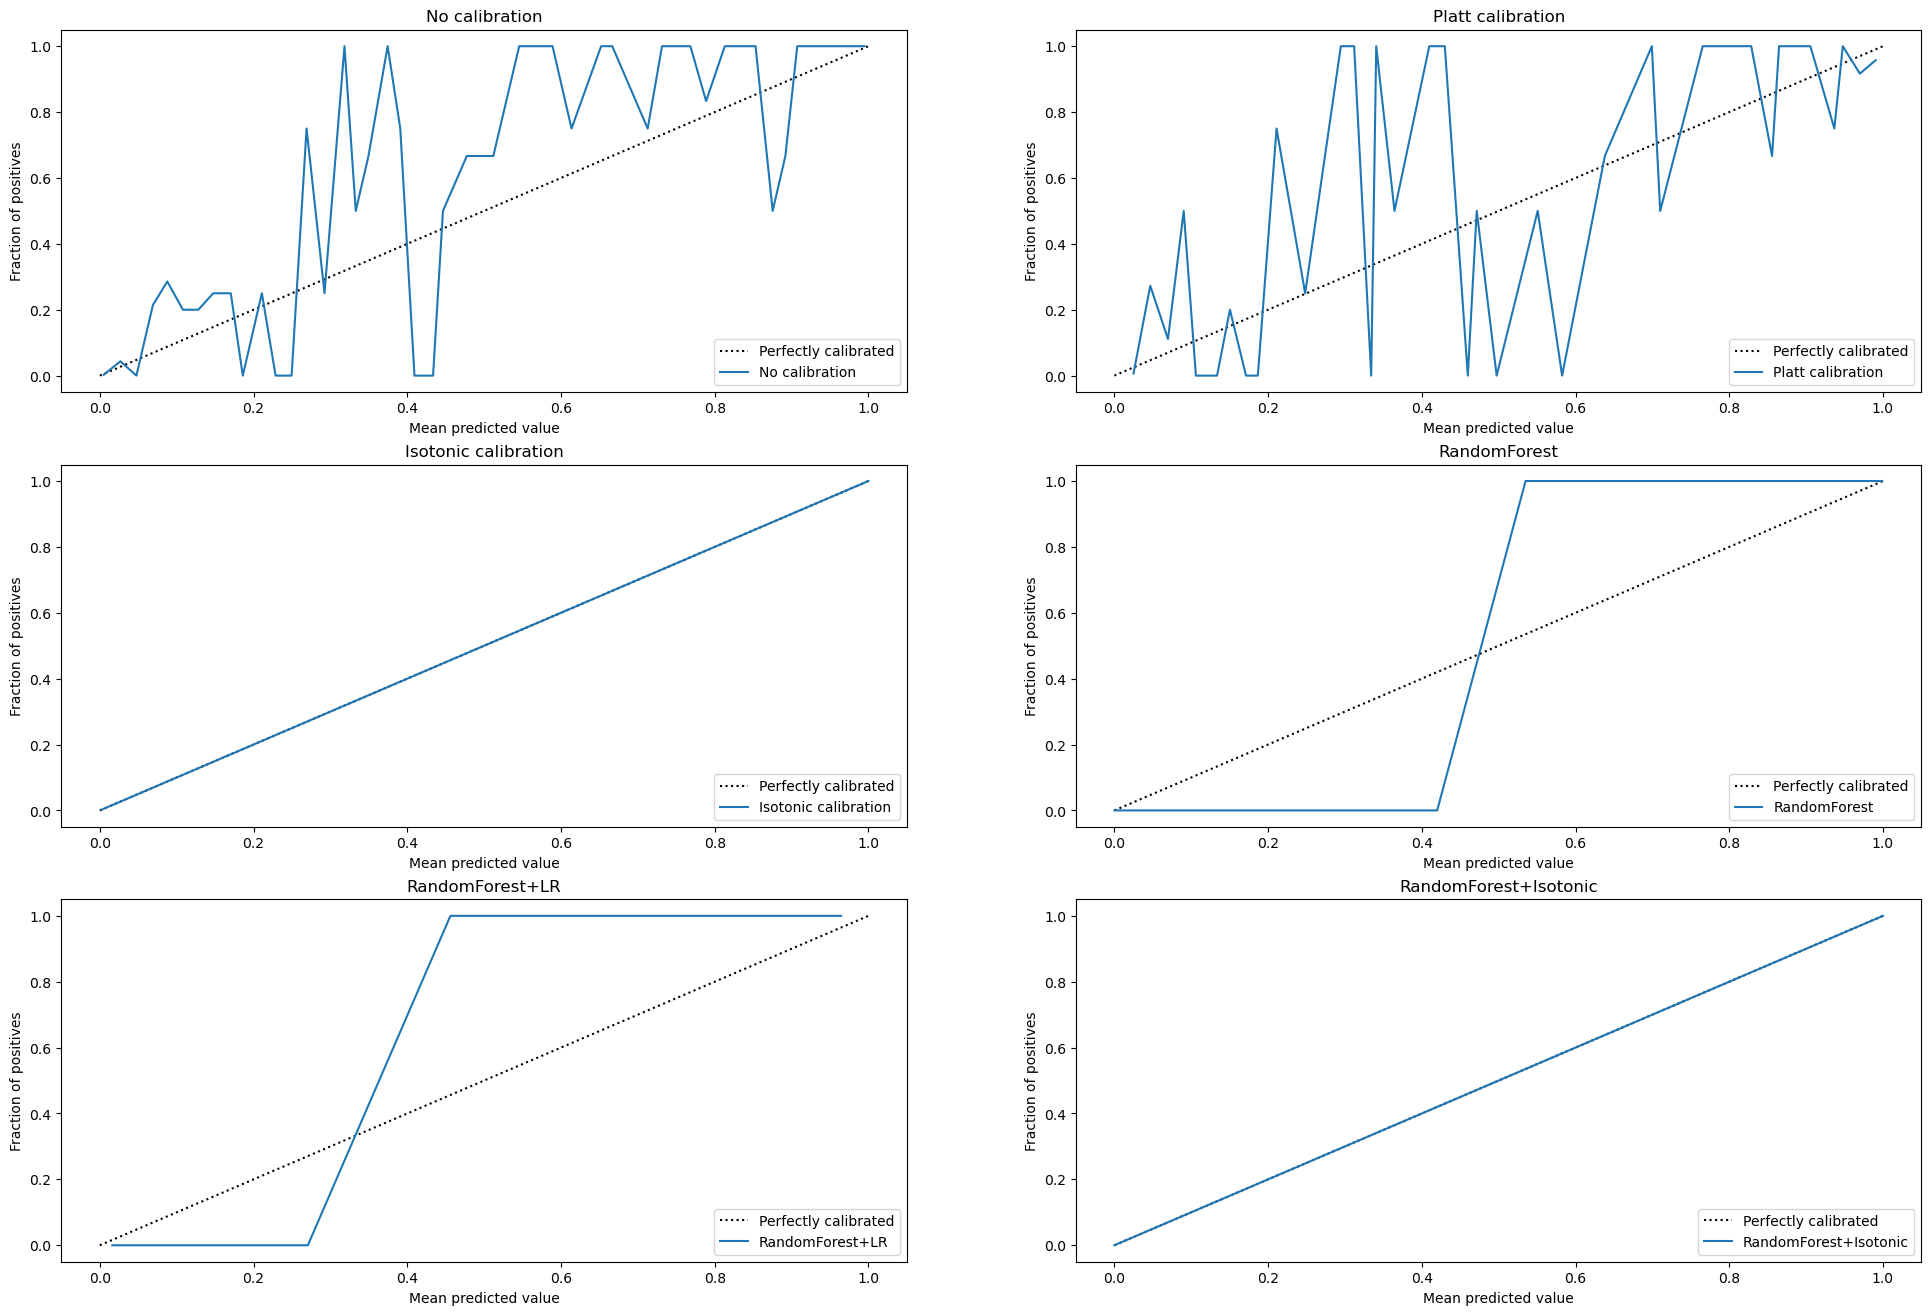

CPU times: user 1.68 s, sys: 169 ms, total: 1.85 s
Wall time: 1.61 s


In [47]:
%%time
from sklearn.calibration import calibration_curve

# получаем значения истинных и предсказанных вероятностей для каждого метода калибровки
fop, mpv = calibration_curve(oof_df.target, oof_df.preds, n_bins=50)
fop_lr, mpv_lr = calibration_curve(oof_df.target, lr_preds_calibrated, n_bins=50)
fop_isor, mpv_isor = calibration_curve(oof_df.target, isor_preds_calibrated, n_bins=50)
fop_rf, mpv_rf = calibration_curve(oof_df.target, rf_preds_calibrated, n_bins=50)
fop_rf_lr, mpv_rf_lr = calibration_curve(oof_df.target, rf_logistic_regress, n_bins=50)
fop_rf_isor, mpv_rf_isor = calibration_curve(oof_df.target, rf_isotonic_regress, n_bins=50)

# создаем список из названий методов калибровки и соответствующих массивов
methods = ["No calibration", "Platt calibration", "Isotonic calibration", "RandomForest", "RandomForest+LR", "RandomForest+Isotonic"]
arrays = [(mpv, fop), (mpv_lr, fop_lr), (mpv_isor, fop_isor), (mpv_rf, fop_rf), (mpv_rf_lr, fop_rf_lr), (mpv_rf_isor, fop_rf_isor)]

# создаем фигуру
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 16))

# используем цикл for для перебора разных методов калибровки и соответствующих массивов
for i in range(6):
    # определяем индексы для осей
    row = i // 2
    col = i % 2
    
    # рисуем график на соответствующей оси с помощью функции plt.plot
    axes[row][col].plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    axes[row][col].plot(arrays[i][0], arrays[i][1], "-", label=methods[i])
    
        # добавляем легенду, заголовок и подписи осей
    axes[row][col].legend(loc="lower right")
    axes[row][col].set_title(methods[i])
    axes[row][col].set_xlabel("Mean predicted value")
    axes[row][col].set_ylabel("Fraction of positives")
    
# показываем фигуру
plt.show()
    

# Submission

In [16]:
X_test = pd.read_csv(path_test).drop(columns='Id')
X_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
def preprocessing_test(df):
      
    # Объедините числовые и категориальные признаки
    num_cols_pre = df.select_dtypes(exclude=['object']).columns.tolist()
    cat_cols_pre = 'EJ'
    cat_cols_pre = df.select_dtypes(include=['object']).columns.tolist()
    features_pre = num_cols_pre + cat_cols_pre

    # Заполните отсутствующие значения средним значением для числовых переменных
    imputer_pre = SimpleImputer(strategy='mean')
    numeric_df_pre = pd.DataFrame(imputer_pre.fit_transform(df[num_cols_pre]), columns=num_cols_pre)

    # Масштабирование числовых переменных с использованием минимаксного масштабирования
    scaler_pre = MinMaxScaler()
    scaled_numeric_df_pre = pd.DataFrame(scaler_pre.fit_transform(numeric_df_pre), columns=num_cols_pre)

    # Кодирование категориальных переменных
    encoder_pre = LabelEncoder()
    encoded_cat_df_pre = pd.DataFrame(encoder_pre.fit_transform(df['EJ']), columns=['EJ'])   

    # Конкатенация масштабированных числовых и кодированных категориальных переменных
    processed_df_pre = pd.concat([scaled_numeric_df_pre, encoded_cat_df_pre], axis=1)

    processed_df_pre.columns = processed_df_pre.columns.str.replace(' ', '')
    
    return processed_df_pre

In [18]:
X_test = preprocessing_test(X_test)
X_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,EJ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [19]:
predictions = model_xgb.predict(xgb.DMatrix(X_test))
predictions_df = pd.DataFrame()
predictions_df['xgb'] = predictions

predictions_df['class_0'] = 1 - predictions
predictions_df['class_1'] = predictions
predictions_df


,xgb,class_0,class_1
0,0.12282,0.87718,0.12282
1,0.12282,0.87718,0.12282
2,0.12282,0.87718,0.12282
3,0.12282,0.87718,0.12282
4,0.12282,0.87718,0.12282


In [20]:
sample_submission = pd.read_csv(path_submission)
sample_submission.head()

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5


In [21]:
submission = pd.DataFrame(columns = sample_submission.columns)
submission['Id'] = sample_submission['Id']
submission[['class_0','class_1']] = predictions_df[['class_0','class_1']]
submission

,Id,class_0,class_1
0,00eed32682bb,0.87718,0.12282
1,010ebe33f668,0.87718,0.12282
2,02fa521e1838,0.87718,0.12282
3,040e15f562a2,0.87718,0.12282
4,046e85c7cc7f,0.87718,0.12282


In [22]:
submission.to_csv('submission.csv',index=False)